In [ ]:
import pandas as pd
import numpy as np
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


True

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import keras.layers as layers
from keras.models import Model
from keras import backend as K
import keras
from keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/data/vaccination_all_tweets.csv")
data

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46054,1376080077054746624,Consumer Grassroots,Kenya,Official Account for Consumer Grassroots Assoc...,2016-11-30 08:14:19,23021,447,19882,True,2021-03-28 07:53:51,Russian Covid-19 vaccine #SputnikV now in Keny...,['SputnikV'],Twitter Web App,1,2,False
46055,1376073682381107201,Michael Muchiri,Nairobi,Civil Engineer working in Kenya. With a Passio...,2011-01-31 17:39:38,1595,3515,6795,False,2021-03-28 07:28:26,Communique on COVID19 Lockdown Effects on USIU...,NaN,Twitter for Android,0,0,False
46056,1376068500360470529,Michael Muchiri,Nairobi,Civil Engineer working in Kenya. With a Passio...,2011-01-31 17:39:38,1595,3515,6795,False,2021-03-28 07:07:51,"Mask is worn on the face, for protection, disg...",NaN,Twitter for Android,0,0,False
46057,1376058766454624261,Stankevicius International,"Dublin, Ireland",Professional trading consultant specializing i...,2020-06-30 12:31:42,16,3,0,False,2021-03-28 06:29:10,"Selling: #NitrileGloves, #1860 #FaceMasks, #Va...","['NitrileGloves', 'FaceMasks', 'Vaccines', 'Sp...",IFTTT,0,1,False


In [ ]:
data.text = data.text.str.lower()
data.text = data.text.apply(lambda x:re.sub('@[^\s]+','',x)) #Remove twitter handlers
data.text = data.text.apply(lambda x:re.sub(r'\B#\S+','',x)) #Remove hashtags
data.text = data.text.apply(lambda x:re.sub(r"http\S+", "", x)) # Remove URLS
data.text = data.text.apply(lambda x:' '.join(re.findall(r'\w+', x))) # Remove all the special characters
data.text = data.text.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', ' ', x)) #remove all single characters
data.text = data.text.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I)) # Substituting multiple spaces with single space



In [ ]:
data['Sentiment']=data['text'].apply(lambda x: SIA().polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))

In [ ]:
def label_p(x):
  prob = [x['pos'],x['neg']]
  p = 0
  if x['pos']>=x['neg']:
    p = 1
  else:
    p = 0
  return p


def label_ne(x):
  prob = [x['pos'],x['neg']]
  p = 0
  if x['neg']>=x['pos']:
    p = 1
  else:
    p = 0
  return p

In [ ]:
data['positive'] = data['Sentiment'].apply(lambda x: label_p(x)) 
data['negative'] = data['Sentiment'].apply(lambda x: label_ne(x))

In [ ]:
data.to_csv('data_with_sa.csv', index = False)

In [ ]:
df = pd.read_csv('data_with_sa.csv')

In [ ]:
positive = pd.read_csv("/data/tweets_postive.csv")
positive['positive'] = 1
pos = positive[0:int(len(positive)*.9)]
pos_test = positive[int(len(positive)*.9):len(positive)]
pos_test.to_csv('/data/test_error_pos.csv', index = False)

negative = pd.read_csv("/data/tweets_negative.csv")
negative['negative'] = 1
neg = negative[0:int(len(negative)*.9)]
neg_test = negative[int(len(negative)*.9):len(negative)]
neg_test.to_csv('/data/test_error_neg.csv', index = False)

In [ ]:
pos = pos[['text', 'positive']]
neg = neg[['text', 'negative']]
df = data[['text', 'positive', 'negative']]

data = pd.concat([pos, neg, df], ignore_index = True).fillna(0)
data.text.dropna(inplace=True)

In [ ]:
data.text = data.text.str.lower()
data.text = data.text.apply(lambda x:re.sub('@[^\s]+','',x)) #Remove twitter handlers
data.text = data.text.apply(lambda x:re.sub(r'\B#\S+','',x)) #Remove hashtags
data.text = data.text.apply(lambda x:re.sub(r"http\S+", "", x)) # Remove URLS
data.text = data.text.apply(lambda x:' '.join(re.findall(r'\w+', x))) # Remove all the special characters
data.text = data.text.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', ' ', x)) #remove all single characters
data.text = data.text.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I)) # Substituting multiple spaces with single space

In [ ]:
data = pd.read_csv('/data/data_with_sa.csv')

In [ ]:
data.dropna(inplace = True)

In [ ]:
len(data[data['positive'] == 0])

11644

In [ ]:
x_array = np.array(data['text'])
y_array = np.array(data[['positive']])

In [ ]:
# Some other functions
def get_max_length(df):
    """
    get max token counts from train data, 
    so we use this number as fixed length input to RNN cell
    """
    max_length = 0
    for row in df['text']:
        if len(row.split(" ")) > max_length:
            max_length = len(row.split(" "))
    return max_length

def get_word2vec_enc(reviews):
    """
    get word2vec value for each word in sentence.
    concatenate word in numpy array, so we can use it as RNN input
    """
    encoded_reviews = []
    for review in reviews:
        tokens = review.split(" ")
        word2vec_embedding = embed(tokens)
        #for num in word2vec_embedding:
        encoded_reviews.append(word2vec_embedding)
    return encoded_reviews
        
def get_padded_encoded_reviews(encoded_reviews,max_length):
    """
    for short sentences, we prepend zero padding so all input to RNN has same length
    """
    padded_reviews_encoding = []
    for enc_review in encoded_reviews:
        zero_padding_cnt = max_length - enc_review.shape[0]
        pad = np.zeros((1, 250))
        for i in range(zero_padding_cnt):
            enc_review = np.concatenate((pad, enc_review), axis=0)
        padded_reviews_encoding.append(enc_review)
    return padded_reviews_encoding

In [ ]:
max_length = get_max_length(data)


In [ ]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/Wiki-words-250/2")

In [ ]:
texto = data['text'].to_list()
texto = get_word2vec_enc(texto)
texto = get_padded_encoded_reviews(texto,max_length)
texto = np.array(texto)

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(texto, y_array, test_size=0.30, random_state=42)

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(32))
#model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=16, validation_data=(X_test,y_test))

Epoch 1/16
1164/1164 [==============================] - 9s 6ms/step - loss: 0.4717 - accuracy: 0.7956 - val_loss: 0.3887 - val_accuracy: 0.8215
Epoch 2/16
1164/1164 [==============================] - 7s 6ms/step - loss: 0.3849 - accuracy: 0.8223 - val_loss: 0.3719 - val_accuracy: 0.8304
Epoch 3/16
1164/1164 [==============================] - 7s 6ms/step - loss: 0.3653 - accuracy: 0.8270 - val_loss: 0.3528 - val_accuracy: 0.8369
Epoch 4/16
1164/1164 [==============================] - 7s 6ms/step - loss: 0.3498 - accuracy: 0.8406 - val_loss: 0.3517 - val_accuracy: 0.8352
Epoch 5/16
1164/1164 [==============================] - 7s 6ms/step - loss: 0.3317 - accuracy: 0.8474 - val_loss: 0.3427 - val_accuracy: 0.8503
Epoch 6/16
1164/1164 [==============================] - 7s 6ms/step - loss: 0.3265 - accuracy: 0.8539 - val_loss: 0.3307 - val_accuracy: 0.8525
Epoch 7/16
1164/1164 [==============================] - 7s 6ms/step - loss: 0.3119 - accuracy: 0.8589 - val_loss: 0.3246 - val_accuracy:

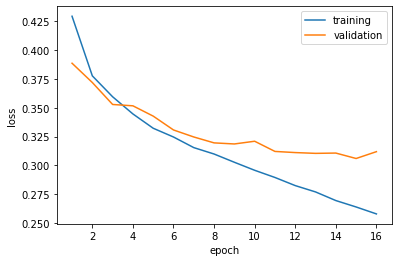

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,16+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
fig = plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

Test

In [ ]:
pos_test = pd.read_csv('/content/drive/MyDrive/test_error_pos.csv')
neg_test = pd.read_csv('/content/drive/MyDrive/test_error_neg.csv')

In [ ]:
data = pd.concat([pos_test, neg_test], ignore_index = True)

In [ ]:
data.text = data.text.str.lower()
data.text = data.text.apply(lambda x:re.sub('@[^\s]+','',x)) #Remove twitter handlers
data.text = data.text.apply(lambda x:re.sub(r'\B#\S+','',x)) #Remove hashtags
data.text = data.text.apply(lambda x:re.sub(r"http\S+", "", x)) # Remove URLS
data.text = data.text.apply(lambda x:' '.join(re.findall(r'\w+', x))) # Remove all the special characters
data.text = data.text.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', ' ', x)) #remove all single characters
data.text = data.text.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I)) # Substituting multiple spaces with single space

In [ ]:
data = data[['Sentiment Label', 'text']]

In [ ]:
y_test = data['Sentiment Label']

In [ ]:
max_length = get_max_length(data)

texto = data['text'].to_list()
texto = get_word2vec_enc(texto)
texto = get_padded_encoded_reviews(texto,max_length)
x_test = np.array(texto)

In [ ]:
predict = model.predict(x_test)

In [ ]:
score = model.evaluate(x_test, y_test) 

26/26 [==============================] - 0s 4ms/step - loss: 0.7270 - accuracy: 0.6578


In [ ]:
predict = np.around(predict)

In [ ]:
predict.tolist()

predict_list = [item for sublist in predict.tolist() for item in sublist]

In [ ]:
data['predicted'] = predict_list

In [ ]:
100*(len(data[data['Sentiment Label'] == data['predicted']])/len(data))

65.77669902912622